In [ ]:
# Install Java
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

# Install Spark
!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
!tar xf spark-3.4.1-bin-hadoop3.tgz
!pip install findspark

In [ ]:
import os

# Set environment variables
os.environ['JAVA_HOME'] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ['SPARK_HOME'] = "/content/spark-3.4.1-bin-hadoop3"

In [ ]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName('AnomalyDetection') \
    .getOrCreate()

# Check Spark version
print("Spark version:", spark.version)

Spark version: 3.4.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
##Define the file path
file_path = '/content/drive/MyDrive/Project Dataset/Mobile_Transactions_for_20240715.csv'

# Read the CSV file into a Spark DataFrame
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Display the schema and first few rows
df.printSchema()
df.show(5)

root
 |-- KEY: string (nullable = true)
 |-- DEBIT_ACCT_NO: long (nullable = true)
 |-- DEBIT_AMOUNT: double (nullable = true)
 |-- CREDIT_ACCT_NO: string (nullable = true)
 |-- PAY_DETAILS: string (nullable = true)
 |-- DEBIT_CUSTOMER: integer (nullable = true)
 |-- CREDIT_CUSTOMER: long (nullable = true)
 |-- INPUTTER: string (nullable = true)
 |-- DATE_TIME: long (nullable = true)

+------------+-------------+------------+----------------+------------------+--------------+---------------+--------------------+----------+
|         KEY|DEBIT_ACCT_NO|DEBIT_AMOUNT|  CREDIT_ACCT_NO|       PAY_DETAILS|DEBIT_CUSTOMER|CREDIT_CUSTOMER|            INPUTTER| DATE_TIME|
+------------+-------------+------------+----------------+------------------+--------------+---------------+--------------------+----------+
|FT24197000H7|1000070483948|    100000.0|   1000079292242| z done via Mobile|    1014974511|     1015840751|8007_GETIY22__OFS...|2407151519|
|FT24197000TM|1000435355386|        50.0|ETB1300

In [ ]:
from pyspark.sql.functions import col, sum as sql_sum

# Create a DataFrame to show the count of null values per column
missing_values = df.select([sql_sum(col(column).isNull().cast("integer")).alias(column) for column in df.columns])

# Show the result
missing_values.show()

+---+-------------+------------+--------------+-----------+--------------+---------------+--------+---------+
|KEY|DEBIT_ACCT_NO|DEBIT_AMOUNT|CREDIT_ACCT_NO|PAY_DETAILS|DEBIT_CUSTOMER|CREDIT_CUSTOMER|INPUTTER|DATE_TIME|
+---+-------------+------------+--------------+-----------+--------------+---------------+--------+---------+
|  0|            0|        7000|             0|       6479|             0|        1901414|       0|        0|
+---+-------------+------------+--------------+-----------+--------------+---------------+--------+---------+



In [ ]:
# Drop rows where 'DEBIT_AMOUNT' is null
df_cleaned = df.dropna(subset=['DEBIT_AMOUNT'])

# Verify the result
df_cleaned.show(5)

+------------+-------------+------------+----------------+------------------+--------------+---------------+--------------------+----------+
|         KEY|DEBIT_ACCT_NO|DEBIT_AMOUNT|  CREDIT_ACCT_NO|       PAY_DETAILS|DEBIT_CUSTOMER|CREDIT_CUSTOMER|            INPUTTER| DATE_TIME|
+------------+-------------+------------+----------------+------------------+--------------+---------------+--------------------+----------+
|FT24197000H7|1000070483948|    100000.0|   1000079292242| z done via Mobile|    1014974511|     1015840751|8007_GETIY22__OFS...|2407151519|
|FT24197000TM|1000435355386|        50.0|ETB1300500060162|  Safari0713183364|    1050873782|           null|20728_A1050873782...|2407151058|
|FT24197001Q8|1000282747174|      5000.0|   1000259349439| 1 done via Mobile|    1038714466|     1036037643|7248_ESEGETMB0001...|2407141452|
|FT24197001QF|1000485257137|         5.0|ETB1300500050162|  Topup 0909531406|    1335901984|           null|18950_SAIDMB10__O...|2407140123|
|FT24197001RM

In [ ]:
from pyspark.sql.functions import col, sum as sql_sum
# Create a DataFrame to show the count of null values per column
missing_values = df_cleaned.select([sql_sum(col(column).isNull().cast("integer")).alias(column) for column in df_cleaned.columns])

# Show the result
missing_values.show()

+---+-------------+------------+--------------+-----------+--------------+---------------+--------+---------+
|KEY|DEBIT_ACCT_NO|DEBIT_AMOUNT|CREDIT_ACCT_NO|PAY_DETAILS|DEBIT_CUSTOMER|CREDIT_CUSTOMER|INPUTTER|DATE_TIME|
+---+-------------+------------+--------------+-----------+--------------+---------------+--------+---------+
|  0|            0|           0|             0|         15|             0|        1901414|       0|        0|
+---+-------------+------------+--------------+-----------+--------------+---------------+--------+---------+



In [ ]:
df_Relevant_column = df_cleaned.drop('INPUTTER')

# Show the result
df_Relevant_column.show(truncate=False)

+------------+-------------+------------+----------------+----------------------+--------------+---------------+----------+
|KEY         |DEBIT_ACCT_NO|DEBIT_AMOUNT|CREDIT_ACCT_NO  |PAY_DETAILS           |DEBIT_CUSTOMER|CREDIT_CUSTOMER|DATE_TIME |
+------------+-------------+------------+----------------+----------------------+--------------+---------------+----------+
|FT24197000H7|1000070483948|100000.0    |1000079292242   |z done via Mobile     |1014974511    |1015840751     |2407151519|
|FT24197000TM|1000435355386|50.0        |ETB1300500060162|Safari0713183364      |1050873782    |null           |2407151058|
|FT24197001Q8|1000282747174|5000.0      |1000259349439   |1 done via Mobile     |1038714466    |1036037643     |2407141452|
|FT24197001QF|1000485257137|5.0         |ETB1300500050162|Topup 0909531406      |1335901984    |null           |2407140123|
|FT24197001RM|1000328876478|30000.0     |1000141723417   |gu done via Mobile    |1044390920    |1021902672     |2407151226|
|FT24197

In [ ]:
from pyspark.sql.functions import to_timestamp, col

# Define the format string for the date time column
date_format = "yyMMddHHmm"

# Convert DATE_TIME to timestamp in cleaned df
Cleaned_df_Time = df_Relevant_column.withColumn('DATE_TIME', to_timestamp(col('DATE_TIME').cast('string'), date_format))
Cleaned_df_Time.show(5)

+------------+-------------+------------+----------------+------------------+--------------+---------------+-------------------+
|         KEY|DEBIT_ACCT_NO|DEBIT_AMOUNT|  CREDIT_ACCT_NO|       PAY_DETAILS|DEBIT_CUSTOMER|CREDIT_CUSTOMER|          DATE_TIME|
+------------+-------------+------------+----------------+------------------+--------------+---------------+-------------------+
|FT24197000H7|1000070483948|    100000.0|   1000079292242| z done via Mobile|    1014974511|     1015840751|2024-07-15 15:19:00|
|FT24197000TM|1000435355386|        50.0|ETB1300500060162|  Safari0713183364|    1050873782|           null|2024-07-15 10:58:00|
|FT24197001Q8|1000282747174|      5000.0|   1000259349439| 1 done via Mobile|    1038714466|     1036037643|2024-07-14 14:52:00|
|FT24197001QF|1000485257137|         5.0|ETB1300500050162|  Topup 0909531406|    1335901984|           null|2024-07-14 01:23:00|
|FT24197001RM|1000328876478|     30000.0|   1000141723417|gu done via Mobile|    1044390920|     

In [ ]:
from pyspark.sql.functions import col

# Change DEBIT_CUSTOMER_ID to string
Cleaned_df = Cleaned_df_Time.withColumn('DEBIT_ACCT_NO', col('DEBIT_ACCT_NO').cast('string'))
Cleaned_df = Cleaned_df.withColumn('CREDIT_ACCT_NO', col('CREDIT_ACCT_NO').cast('string'))
Cleaned_df = Cleaned_df.withColumn('DEBIT_CUSTOMER', col('DEBIT_CUSTOMER').cast('string'))
Cleaned_df = Cleaned_df.withColumn('CREDIT_CUSTOMER', col('CREDIT_CUSTOMER').cast('string'))
# Display the DataFrame to check the changes
Cleaned_df.show(5)

# Check the schema to confirm the data type change
Cleaned_df.printSchema()

+------------+-------------+------------+----------------+------------------+--------------+---------------+-------------------+
|         KEY|DEBIT_ACCT_NO|DEBIT_AMOUNT|  CREDIT_ACCT_NO|       PAY_DETAILS|DEBIT_CUSTOMER|CREDIT_CUSTOMER|          DATE_TIME|
+------------+-------------+------------+----------------+------------------+--------------+---------------+-------------------+
|FT24197000H7|1000070483948|    100000.0|   1000079292242| z done via Mobile|    1014974511|     1015840751|2024-07-15 15:19:00|
|FT24197000TM|1000435355386|        50.0|ETB1300500060162|  Safari0713183364|    1050873782|           null|2024-07-15 10:58:00|
|FT24197001Q8|1000282747174|      5000.0|   1000259349439| 1 done via Mobile|    1038714466|     1036037643|2024-07-14 14:52:00|
|FT24197001QF|1000485257137|         5.0|ETB1300500050162|  Topup 0909531406|    1335901984|           null|2024-07-14 01:23:00|
|FT24197001RM|1000328876478|     30000.0|   1000141723417|gu done via Mobile|    1044390920|     

In [ ]:
from pyspark.sql.functions import when, col

Cleaned_df = Cleaned_df.withColumn(
    'transaction_type',
    when(col('CREDIT_ACCT_NO') == 'ETB1300500060162', 'Safari')
    .when(col('CREDIT_ACCT_NO') == 'ETB1300500050162', 'Popup')
    .when(col('CREDIT_ACCT_NO') == 'ETB1753600910162', 'telebirr')
    .when(col('CREDIT_ACCT_NO') == 'ETB1263500980162', 'Mpesa')
    .when(col('CREDIT_ACCT_NO') == 'ETB1753600020162', 'CBE birr')
    .otherwise('Account to account')
)

Cleaned_df.show(5)


+------------+-------------+------------+----------------+------------------+--------------+---------------+-------------------+------------------+
|         KEY|DEBIT_ACCT_NO|DEBIT_AMOUNT|  CREDIT_ACCT_NO|       PAY_DETAILS|DEBIT_CUSTOMER|CREDIT_CUSTOMER|          DATE_TIME|  transaction_type|
+------------+-------------+------------+----------------+------------------+--------------+---------------+-------------------+------------------+
|FT24197000H7|1000070483948|    100000.0|   1000079292242| z done via Mobile|    1014974511|     1015840751|2024-07-15 15:19:00|Account to account|
|FT24197000TM|1000435355386|        50.0|ETB1300500060162|  Safari0713183364|    1050873782|           null|2024-07-15 10:58:00|            Safari|
|FT24197001Q8|1000282747174|      5000.0|   1000259349439| 1 done via Mobile|    1038714466|     1036037643|2024-07-14 14:52:00|Account to account|
|FT24197001QF|1000485257137|         5.0|ETB1300500050162|  Topup 0909531406|    1335901984|           null|2024

In [ ]:
from pyspark.sql.functions import when, col, regexp_extract

# Extract the numeric sequence from PAY_DETAILS if CREDIT_ACCT_NO contains 'ETB'
extracted_value = regexp_extract(col('PAY_DETAILS'), '[0-9]+', 0)

# Create the new column 'generated_account' based on the condition
Cleaned_df = Cleaned_df.withColumn(
    'generated_account',
    when(col('CREDIT_ACCT_NO').contains('ETB'), extracted_value)
    .otherwise(col('CREDIT_ACCT_NO'))
)

Cleaned_df.show(500)


+------------+-------------+------------+----------------+--------------------+--------------+---------------+-------------------+------------------+-----------------+
|         KEY|DEBIT_ACCT_NO|DEBIT_AMOUNT|  CREDIT_ACCT_NO|         PAY_DETAILS|DEBIT_CUSTOMER|CREDIT_CUSTOMER|          DATE_TIME|  transaction_type|generated_account|
+------------+-------------+------------+----------------+--------------------+--------------+---------------+-------------------+------------------+-----------------+
|FT24197000H7|1000070483948|    100000.0|   1000079292242|   z done via Mobile|    1014974511|     1015840751|2024-07-15 15:19:00|Account to account|    1000079292242|
|FT24197000TM|1000435355386|        50.0|ETB1300500060162|    Safari0713183364|    1050873782|           null|2024-07-15 10:58:00|            Safari|       0713183364|
|FT24197001Q8|1000282747174|      5000.0|   1000259349439|   1 done via Mobile|    1038714466|     1036037643|2024-07-14 14:52:00|Account to account|    1000259

In [ ]:
# Drop the specified columns from the DataFrame
Cleaned_df = Cleaned_df.drop('CREDIT_ACCT_NO', 'PAY_DETAILS', 'CREDIT_CUSTOMER')
# Rename the 'generated_account' column to 'CREDIT_ACCT_NO'
Cleaned_df = Cleaned_df.withColumnRenamed('generated_account', 'CREDIT_ACCT_NO')
# Show the updated DataFrame
Cleaned_df.show(5)


+------------+-------------+------------+--------------+-------------------+------------------+--------------+
|         KEY|DEBIT_ACCT_NO|DEBIT_AMOUNT|DEBIT_CUSTOMER|          DATE_TIME|  transaction_type|CREDIT_ACCT_NO|
+------------+-------------+------------+--------------+-------------------+------------------+--------------+
|FT24197000H7|1000070483948|    100000.0|    1014974511|2024-07-15 15:19:00|Account to account| 1000079292242|
|FT24197000TM|1000435355386|        50.0|    1050873782|2024-07-15 10:58:00|            Safari|    0713183364|
|FT24197001Q8|1000282747174|      5000.0|    1038714466|2024-07-14 14:52:00|Account to account| 1000259349439|
|FT24197001QF|1000485257137|         5.0|    1335901984|2024-07-14 01:23:00|             Popup|    0909531406|
|FT24197001RM|1000328876478|     30000.0|    1044390920|2024-07-15 12:26:00|Account to account| 1000141723417|
+------------+-------------+------------+--------------+-------------------+------------------+--------------+
o

In [ ]:
dict(Cleaned_df.dtypes)['CREDIT_ACCT_NO']

'string'

In [ ]:
from pyspark.sql.functions import length
low_acc=Cleaned_df.filter(length(Cleaned_df["CREDIT_ACCT_NO"]) < 9)
low_acc.show()

+------------+-------------+------------+--------------+-------------------+------------------+--------------+
|         KEY|DEBIT_ACCT_NO|DEBIT_AMOUNT|DEBIT_CUSTOMER|          DATE_TIME|  transaction_type|CREDIT_ACCT_NO|
+------------+-------------+------------+--------------+-------------------+------------------+--------------+
|FT2419700NZD|1000455312624|       502.0|    1016910295|2024-07-15 06:39:00|Account to account|              |
|FT24197029MV|1000145055222|       502.0|    1022281267|2024-07-14 08:27:00|Account to account|              |
|FT2419702F3M|1000079137597|      1004.0|    1015827119|2024-07-14 10:59:00|Account to account|              |
|FT2419702VYZ|1000038408112|      5020.0|    1004491580|2024-07-14 17:55:00|Account to account|              |
|FT24197037RG|1000021537016|     20048.0|    1002532826|2024-07-15 13:22:00|Account to account|              |
|FT2419704QPH|1000095385927|       401.6|    1017491515|2024-07-13 23:38:00|Account to account|             1|
|

In [ ]:
low_acc.count()

123206

In [ ]:
from pyspark.sql.functions import length, col
# Filter rows where CREDIT_ACCT_NO is empty

nulll_credit = Cleaned_df.filter(col("CREDIT_ACCT_NO") =="")

# Group by PAY_DETAILS
groupedd_df = nulll_credit.groupBy("transaction_type").count()
groupedd_df.show()

+------------------+-----+
|  transaction_type|count|
+------------------+-----+
|Account to account|81797|
+------------------+-----+



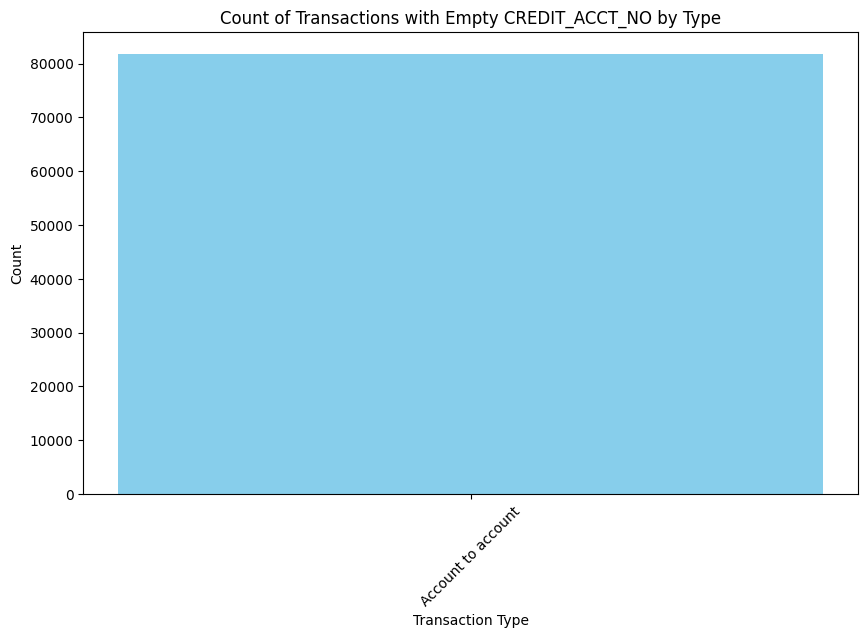

In [ ]:
import matplotlib.pyplot as plt
# Collect the results to a Pandas DataFrame
pandas_df = groupedd_df.toPandas()

# Plot the results using matplotlib
plt.figure(figsize=(10, 6))
plt.bar(pandas_df["transaction_type"], pandas_df["count"], color='skyblue')
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.title("Count of Transactions with Empty CREDIT_ACCT_NO by Type")
plt.xticks(rotation=45)
plt.show()

In [ ]:
from pyspark.sql.functions import col
import pandas as pd
import plotly.express as px



# Convert to Pandas DataFrame
groupedd_df_pd = groupedd_df.toPandas()

# Bar Chart
bar_chart = px.bar(
    groupedd_df_pd,
    x='transaction_type',
    y='count',
    title='Count of Transactions with Empty CREDIT_ACCT_NO by Transaction Type',
    labels={'transaction_type': 'Transaction Type', 'count': 'Transaction Count'}
)
bar_chart.update_layout(
    width=1000,
    height=600,
    xaxis_title='Transaction Type',
    yaxis_title='Transaction Count'
)
bar_chart.show()




In [ ]:
from pyspark.sql.functions import length, col
# Filter rows where CREDIT_ACCT_NO is empty

null_credit = Cleaned_df.filter(length(col("CREDIT_ACCT_NO")) <9 )

# Group by PAY_DETAILS
grouped_df = null_credit.groupBy("transaction_type").count()
grouped_df.show()

+------------------+------+
|  transaction_type| count|
+------------------+------+
|Account to account|122722|
|          CBE birr|   484|
+------------------+------+



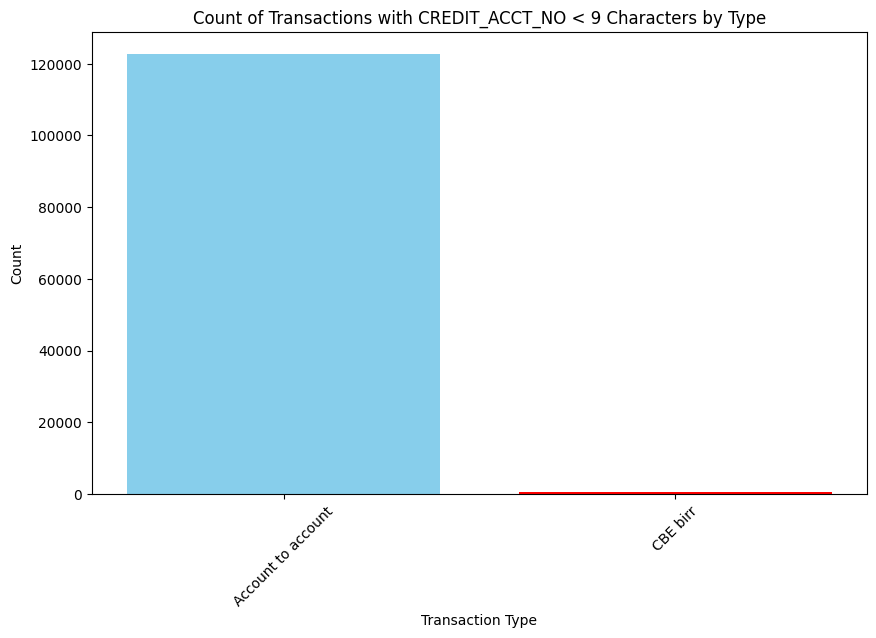

In [ ]:
# Collect the results to a Pandas DataFrame
pandas_df = grouped_df.toPandas()

# Define colors for each transaction type
colors = ['skyblue', 'red', 'salmon', 'orange', 'purple', 'pink', 'gold']

# Plot the results using matplotlib
plt.figure(figsize=(10, 6))
plt.bar(pandas_df["transaction_type"], pandas_df["count"], color=colors[:len(pandas_df)])
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.title("Count of Transactions with CREDIT_ACCT_NO < 9 Characters by Type")
plt.xticks(rotation=45)

plt.show()

In [ ]:
from pyspark.sql.functions import length, col
import pandas as pd
import plotly.express as px



# Convert to Pandas DataFrame
grouped_df_pd = grouped_df.toPandas()

# Bar Chart
bar_chart = px.bar(
    grouped_df_pd,
    x='transaction_type',
    y='count',
    title='Count of Transactions with CREDIT_ACCT_NO less than 9 characters by Transaction Type',
    labels={'transaction_type': 'Transaction Type', 'count': 'Transaction Count'}
)
bar_chart.update_layout(
    width=1000,
    height=600,
    xaxis_title='Transaction Type',
    yaxis_title='Transaction Count'
)
bar_chart.show()



In [ ]:
# Pie Chart
pie_chart = px.pie(
    grouped_df_pd,
    values='count',
    names='transaction_type',
    title='Transaction Count Distribution with CREDIT_ACCT_NO less than 9 characters by Transaction Type'
)
pie_chart.update_layout(
    width=800,
    height=600
)
pie_chart.show()


**Number of unique CREDIT_ACCT_NO per DEBIT_ACCT_NO**

In [ ]:
from pyspark.sql.functions import countDistinct

# Count the number of unique CREDIT_ACCT_NO per DEBIT_ACCT_NO
credit_count_per_debit = Cleaned_df.groupBy('DEBIT_ACCT_NO').agg(
    countDistinct('CREDIT_ACCT_NO').alias('unique_credit_count')
)

# Show the result
credit_count_per_debit.show()


+-------------+-------------------+
|DEBIT_ACCT_NO|unique_credit_count|
+-------------+-------------------+
|1000539604485|                  2|
|1000450856332|                  1|
|1000467447867|                  3|
|1000020302236|                  5|
|1000523938968|                  4|
|1000592507928|                  1|
|1000548982093|                  1|
|1000255572982|                  2|
|1000040822686|                  3|
|1000426372138|                  2|
|1000357108865|                  2|
|1000263855535|                  2|
|1000202780532|                  2|
|1000433277795|                  1|
|1000128436921|                  5|
|1000375359735|                  2|
|1000223068549|                  2|
|1000241048504|                  1|
|1000189988528|                  2|
|1000417107332|                  4|
+-------------+-------------------+
only showing top 20 rows



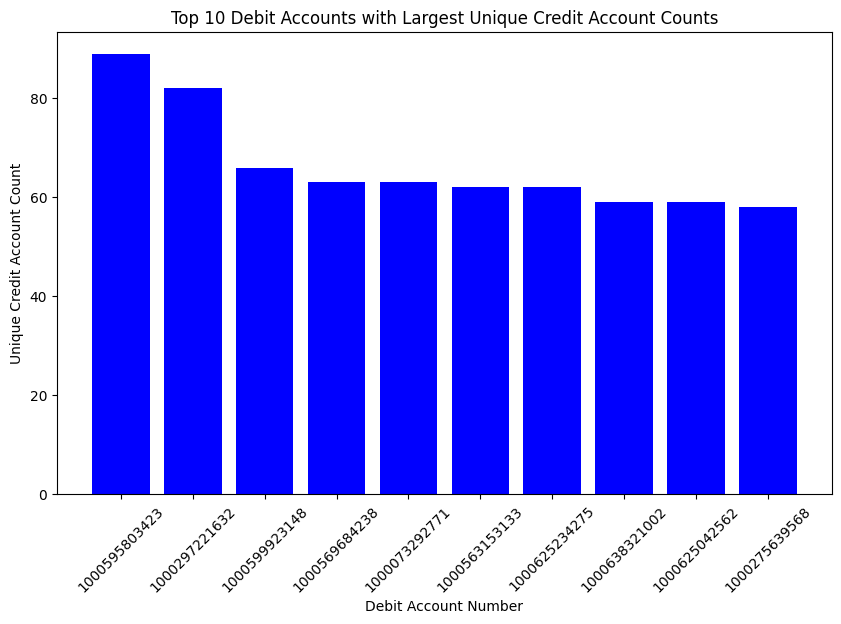

In [ ]:
# Sort and select the top 10 entries
top_10_credit_count_per_debit = credit_count_per_debit.orderBy(col("unique_credit_count").desc()).limit(10)



# Collect the results to a Pandas DataFrame
pandas_df = top_10_credit_count_per_debit.toPandas()

# Plot the results using matplotlib
plt.figure(figsize=(10, 6))
plt.bar(pandas_df["DEBIT_ACCT_NO"], pandas_df["unique_credit_count"], color='blue')
plt.xlabel("Debit Account Number")
plt.ylabel("Unique Credit Account Count")
plt.title("Top 10 Debit Accounts with Largest Unique Credit Account Counts")
plt.xticks(rotation=45)

# Show plot
plt.show()

In [ ]:
from pyspark.sql.functions import countDistinct, col
import pandas as pd
import plotly.express as px



# Convert to Pandas DataFrame
credit_count_per_debit_pd = credit_count_per_debit.toPandas()

# Sort and select the top 10 DEBIT_ACCT_NO by unique_credit_count
top_10_credit_count_per_debit_pd = credit_count_per_debit_pd.sort_values(by='unique_credit_count', ascending=False).head(10)

# Bar Chart
bar_chart = px.bar(
    top_10_credit_count_per_debit_pd,
    x='DEBIT_ACCT_NO',
    y='unique_credit_count',
    title='Top 10 DEBIT_ACCT_NO by Number of Unique CREDIT_ACCT_NO',
    labels={'DEBIT_ACCT_NO': 'Debit Account Number', 'unique_credit_count': 'Unique Credit Account Count'},
    color_discrete_sequence=['purple']  # Set bar color to purple
)
bar_chart.update_layout(
    width=1000,
    height=600,
    xaxis_title='Debit Account Number',
    yaxis_title='Unique Credit Account Count'
)
bar_chart.show()


**Unique CREDIT_ACCT_NO Per Each DEBIT_ACCT_NO**

In [ ]:
from pyspark.sql.functions import collect_set

# Collect unique CREDIT_ACCT_NO values for each DEBIT_ACCT_NO
unique_credit_per_debit = Cleaned_df.groupBy('DEBIT_ACCT_NO').agg(
    collect_set('CREDIT_ACCT_NO').alias('unique_credit_accounts')
)

# Show the result
unique_credit_per_debit.show(truncate=False)


+-------------+------------------------------+
|DEBIT_ACCT_NO|unique_credit_accounts        |
+-------------+------------------------------+
|1000000001086|[0913094293]                  |
|1000000001418|[0920889552]                  |
|1000000001434|[0913832583]                  |
|1000000001442|[1000338488118, 1000217803776]|
|1000000001485|[0911110923]                  |
|1000000001507|[966927503]                   |
|1000000001582|[1000079768298]               |
|1000000001639|[912119808]                   |
|1000000002015|[1000430779706, 1000003638597]|
|1000000002031|[1000627613869]               |
|1000000002047|[1000140737686]               |
|1000000002074|[956258802]                   |
|1000000002082|[1000219874417]               |
|1000000002171|[0913718670]                  |
|1000000002198|[1000359886946]               |
|1000000002244|[1000085012577, 1000173028378]|
|1000000002325|[920308479, 1000004300312]    |
|1000000002384|[1000140636588]               |
|100000000248

**Unique transaction types for each DEBIT_ACCT_NO**

In [ ]:
from pyspark.sql.functions import collect_set

# Aggregate the unique transaction types for each DEBIT_ACCT_NO
transaction_type_per_debit = Cleaned_df.groupBy('DEBIT_ACCT_NO').agg(
    collect_set('transaction_type').alias('transaction_types')
)

# Show the result
transaction_type_per_debit.show(truncate=False)


+-------------+------------------------------+
|DEBIT_ACCT_NO|transaction_types             |
+-------------+------------------------------+
|1000000001086|[Popup]                       |
|1000000001418|[Popup]                       |
|1000000001434|[Popup]                       |
|1000000001442|[Account to account]          |
|1000000001485|[Popup]                       |
|1000000001507|[telebirr]                    |
|1000000001582|[Account to account]          |
|1000000001639|[CBE birr]                    |
|1000000002015|[Account to account]          |
|1000000002031|[Account to account]          |
|1000000002047|[Account to account]          |
|1000000002074|[telebirr]                    |
|1000000002082|[Account to account]          |
|1000000002171|[Popup]                       |
|1000000002198|[Account to account]          |
|1000000002244|[Account to account]          |
|1000000002325|[Account to account, telebirr]|
|1000000002384|[Account to account]          |
|100000000248

In [ ]:
from pyspark.sql.functions import countDistinct

# Count the number of unique DEBIT_ACCT_NO per transaction type
Debit_count_per_TranType = Cleaned_df.groupBy('transaction_type').agg(
    countDistinct('DEBIT_ACCT_NO').alias('unique_debit_count_per_transaction_type')
)

# Show the result
Debit_count_per_TranType.show()

+------------------+---------------------------------------+
|  transaction_type|unique_debit_count_per_transaction_type|
+------------------+---------------------------------------+
|Account to account|                                1449156|
|             Mpesa|                                  13849|
|            Safari|                                 102418|
|          telebirr|                                 189238|
|             Popup|                                 903854|
|          CBE birr|                                  58747|
+------------------+---------------------------------------+



([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Account to account'),
  Text(1, 0, 'Mpesa'),
  Text(2, 0, 'Safari'),
  Text(3, 0, 'telebirr'),
  Text(4, 0, 'Popup'),
  Text(5, 0, 'CBE birr')])

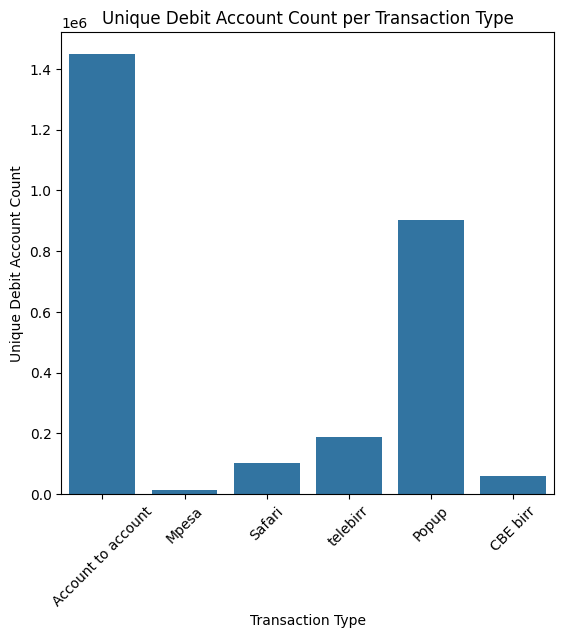

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Convert to Pandas DataFrame
Debit_count_per_TranType_pd = Debit_count_per_TranType.toPandas()

# Plotting using Seaborn and Matplotlib
plt.figure(figsize=(14, 6))

# Bar Chart
plt.subplot(1, 2, 1)
sns.barplot(data=Debit_count_per_TranType_pd, x='transaction_type', y='unique_debit_count_per_transaction_type')
plt.title('Unique Debit Account Count per Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Unique Debit Account Count')
plt.xticks(rotation=45)



In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go


# Bar Chart
bar_chart = px.bar(
    Debit_count_per_TranType_pd,
    x='transaction_type',
    y='unique_debit_count_per_transaction_type',
    title='Unique Debit Account Count per Transaction Type'
)
bar_chart.update_layout(
    width=1000,
    height=600,
    xaxis_title='Transaction Type',
    yaxis_title='Unique Debit Account Count'
)
bar_chart.show()



In [ ]:
from pyspark.sql.functions import countDistinct

# Count the Transaction amount  by transaction type
transaction_amount_per_TranType = Cleaned_df.groupBy('transaction_type').agg(
     sum('DEBIT_AMOUNT').alias('total_transaction_amount_per transaction type')
)

# Show the result
transaction_amount_per_TranType.show()

+------------------+---------------------------------------------+
|  transaction_type|total_transaction_amount_per transaction type|
+------------------+---------------------------------------------+
|Account to account|                         2.540000505351071...|
|             Mpesa|                                   5338962.36|
|            Safari|                                    5774800.0|
|          telebirr|                          8.333477718399999E8|
|             Popup|                          4.653301170999998E7|
|          CBE birr|                                9.667362808E7|
+------------------+---------------------------------------------+



In [ ]:
from pyspark.sql.functions import sum
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Count the total transaction amount by transaction type
transaction_amount_per_TranType = Cleaned_df.groupBy('transaction_type').agg(
     sum('DEBIT_AMOUNT').alias('total_transaction_amount_per_transaction_type')
)

# Convert to Pandas DataFrame
transaction_amount_per_TranType_pd = transaction_amount_per_TranType.toPandas()

# Bar Chart
bar_chart = px.bar(
    transaction_amount_per_TranType_pd,
    x='transaction_type',
    y='total_transaction_amount_per_transaction_type',
    title='Total Transaction Amount per Transaction Type',
    labels={'transaction_type': 'Transaction Type', 'total_transaction_amount_per_transaction_type': 'Total Transaction Amount'}
)
bar_chart.update_layout(
    width=1000,
    height=600,
    xaxis_title='Transaction Type',
    yaxis_title='Total Transaction Amount'
)
bar_chart.show()




**Total Transaction Amount , Average Transaction Amount and Transaction Ferequency Per Debit Account**

In [ ]:
from pyspark.sql.functions import sum,count,avg

Transaction_By_Debit_Account = Cleaned_df.groupBy('DEBIT_ACCT_NO').agg(
    sum('DEBIT_AMOUNT').alias('total_transaction_amount'),
    avg('DEBIT_AMOUNT').alias('Average Transaction Amount'),
    count('key').alias('Transaction Ferequency')

)

Transaction_By_Debit_Account.show()

+-------------+------------------------+--------------------------+----------------------+
|DEBIT_ACCT_NO|total_transaction_amount|Average Transaction Amount|Transaction Ferequency|
+-------------+------------------------+--------------------------+----------------------+
|1000324096888|                    15.0|                       7.5|                     2|
|1000153022848|                  1030.0|                     257.5|                     4|
|1000224743614|                   500.0|                     250.0|                     2|
|1000182463397|                  1500.0|                    1500.0|                     1|
|1000510023289|                  3000.0|                    3000.0|                     1|
|1000557314761|                    25.0|                      25.0|                     1|
|1000496720249|                  1050.0|                     262.5|                     4|
|1000534277125|                  9500.0|        3166.6666666666665|                     3|

**Transaction Trends Over Time (Hourly)**

In [ ]:
from pyspark.sql import functions as F
# Group by hour and aggregate transaction count and total debit amount
hourly_transactions = Cleaned_df.groupBy(F.hour("DATE_TIME").alias("hour")).agg(
    F.count("KEY").alias("transaction_count"),
    F.sum("DEBIT_AMOUNT").alias("total_debit_amount"),

).orderBy("hour")

# Convert to Pandas DataFrame for plotting
hourly_transactions_pd = hourly_transactions.toPandas()

In [ ]:
# Determine peak hours for transaction count and total debit amount
peak_transaction_hour = hourly_transactions_pd.loc[hourly_transactions_pd['transaction_count'].idxmax()]['hour']
peak_debit_amount_hour = hourly_transactions_pd.loc[hourly_transactions_pd['total_debit_amount'].idxmax()]['hour']

print(f"Peak hour for transaction count: {peak_transaction_hour}")
print(f"Peak hour for total debit amount: {peak_debit_amount_hour}")

Peak hour for transaction count: 13.0
Peak hour for total debit amount: 15.0


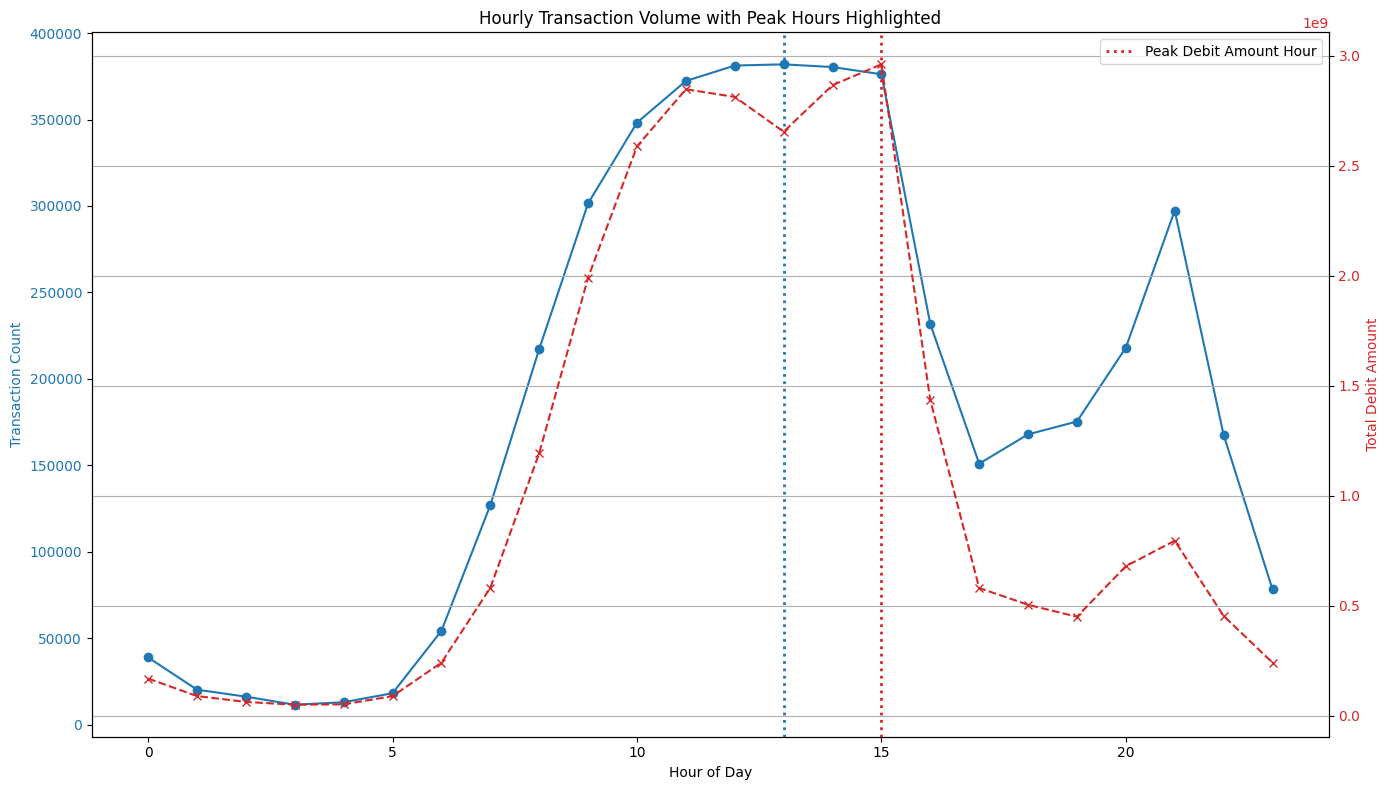

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotting
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot transaction count
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Transaction Count', color='tab:blue')
ax1.plot(hourly_transactions_pd['hour'], hourly_transactions_pd['transaction_count'], color='tab:blue', marker='o', linestyle='-')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a secondary y-axis to plot total_debit_amount
ax2 = ax1.twinx()
ax2.set_ylabel('Total Debit Amount', color='tab:red')
ax2.plot(hourly_transactions_pd['hour'], hourly_transactions_pd['total_debit_amount'], color='tab:red', marker='x', linestyle='--')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Highlight peak hours
ax1.axvline(x=peak_transaction_hour, color='tab:blue', linestyle=':', linewidth=2, label='Peak Transaction Hour')
ax2.axvline(x=peak_debit_amount_hour, color='tab:red', linestyle=':', linewidth=2, label='Peak Debit Amount Hour')

plt.title('Hourly Transaction Volume with Peak Hours Highlighted')
fig.tight_layout()
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
from pyspark.sql import functions as F
import pandas as pd
import plotly.graph_objects as go



# Create a combined line chart using Plotly
fig = go.Figure()

# Add transaction count line
fig.add_trace(go.Scatter(
    x=hourly_transactions_pd['hour'],
    y=hourly_transactions_pd['transaction_count'],
    mode='lines+markers',
    name='Transaction Count',
    line=dict(color='blue')
))

# Add total debit amount line
fig.add_trace(go.Scatter(
    x=hourly_transactions_pd['hour'],
    y=hourly_transactions_pd['total_debit_amount'],
    mode='lines+markers',
    name='Total Debit Amount',
    line=dict(color='red'),
    yaxis='y2'
))

# Add vertical lines for peak hours
fig.add_vline(x=peak_transaction_hour, line=dict(color='blue', dash='dash'), name='Peak Transaction Hour')
fig.add_vline(x=peak_debit_amount_hour, line=dict(color='red', dash='dash'), name='Peak Debit Amount Hour')

# Update layout with dual y-axes
fig.update_layout(
    title='Hourly Transaction Count and Total Debit Amount',
    xaxis=dict(title='Hour of Day'),
    yaxis=dict(title='Transaction Count', titlefont=dict(color='blue'), tickfont=dict(color='blue')),
    yaxis2=dict(title='Total Debit Amount', titlefont=dict(color='red'), tickfont=dict(color='red'), overlaying='y', side='right'),
    width=1000,
    height=600
)

fig.show()


**Transaction Overtime (Weekly)**

In [ ]:
# Weekly transaction volume
from pyspark.sql import functions as F

# Group by the day of the week, aggregate transaction counts and total debit amount
Day_of_Week_transactions = (
    Cleaned_df
    .groupBy(F.dayofweek("DATE_TIME").alias("Day_of_Week"))
    .agg(
        F.count("*").alias("Transaction_Count"),
        F.sum("DEBIT_AMOUNT").alias("Total_Debit_Amount")
    )
    .orderBy("Day_of_Week")
)

# Show the result
##Day_of_Week_transactions.show()

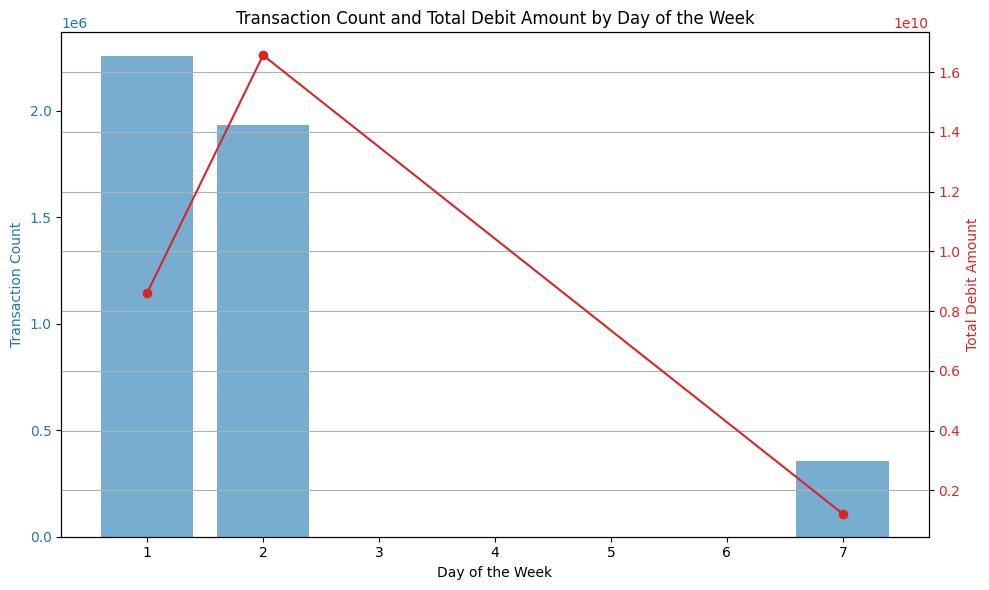

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the PySpark DataFrame to a pandas DataFrame
Day_of_Week_transactions_pd = Day_of_Week_transactions.toPandas()

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the transaction count
ax1.set_xlabel('Day of the Week')
ax1.set_ylabel('Transaction Count', color='tab:blue')
ax1.bar(Day_of_Week_transactions_pd['Day_of_Week'],
        Day_of_Week_transactions_pd['Transaction_Count'],
        color='tab:blue', alpha=0.6, label='Transaction Count')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for the total debit amount
ax2 = ax1.twinx()
ax2.set_ylabel('Total Debit Amount', color='tab:red')
ax2.plot(Day_of_Week_transactions_pd['Day_of_Week'],
         Day_of_Week_transactions_pd['Total_Debit_Amount'],
         color='tab:red', marker='o', linestyle='-', label='Total Debit Amount')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and Grid
plt.title('Transaction Count and Total Debit Amount by Day of the Week')
fig.tight_layout()
plt.grid()

# Show plot
plt.show()

In [ ]:
import pandas as pd
import plotly.graph_objects as go

# Convert the PySpark DataFrame to a Pandas DataFrame
Day_of_Week_transactions_pd = Day_of_Week_transactions.toPandas()

# Create a combined line and bar chart using Plotly
fig = go.Figure()

# Add a bar trace for Transaction Count
fig.add_trace(go.Bar(
    x=Day_of_Week_transactions_pd['Day_of_Week'],
    y=Day_of_Week_transactions_pd['Transaction_Count'],
    name='Transaction Count',
    marker_color='blue'
))

# Add a line trace for Total Debit Amount
fig.add_trace(go.Scatter(
    x=Day_of_Week_transactions_pd['Day_of_Week'],
    y=Day_of_Week_transactions_pd['Total_Debit_Amount'],
    name='Total Debit Amount',
    mode='lines+markers',
    marker=dict(color='red'),
    yaxis='y2'
))

# Update layout with dual y-axes
fig.update_layout(
    title='Transaction Count and Total Debit Amount by Day of the Week',
    xaxis_title='Day of the Week',
    yaxis_title='Transaction Count',
    yaxis2=dict(
        title='Total Debit Amount',
        overlaying='y',
        side='right'
    ),
    width=1000,
    height=600,
    barmode='group'
)

fig.show()


**Transaction Trends Over Time (Daily)**

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.functions import to_date

# Daily transaction volume
daily_transactions = Cleaned_df.groupBy(F.to_date("DATE_TIME").alias("date")).agg(
    F.count("KEY").alias("transaction_count"),
    F.sum("DEBIT_AMOUNT").alias("total_debit_amount")
).orderBy("date")

##daily_transactions.show(5)

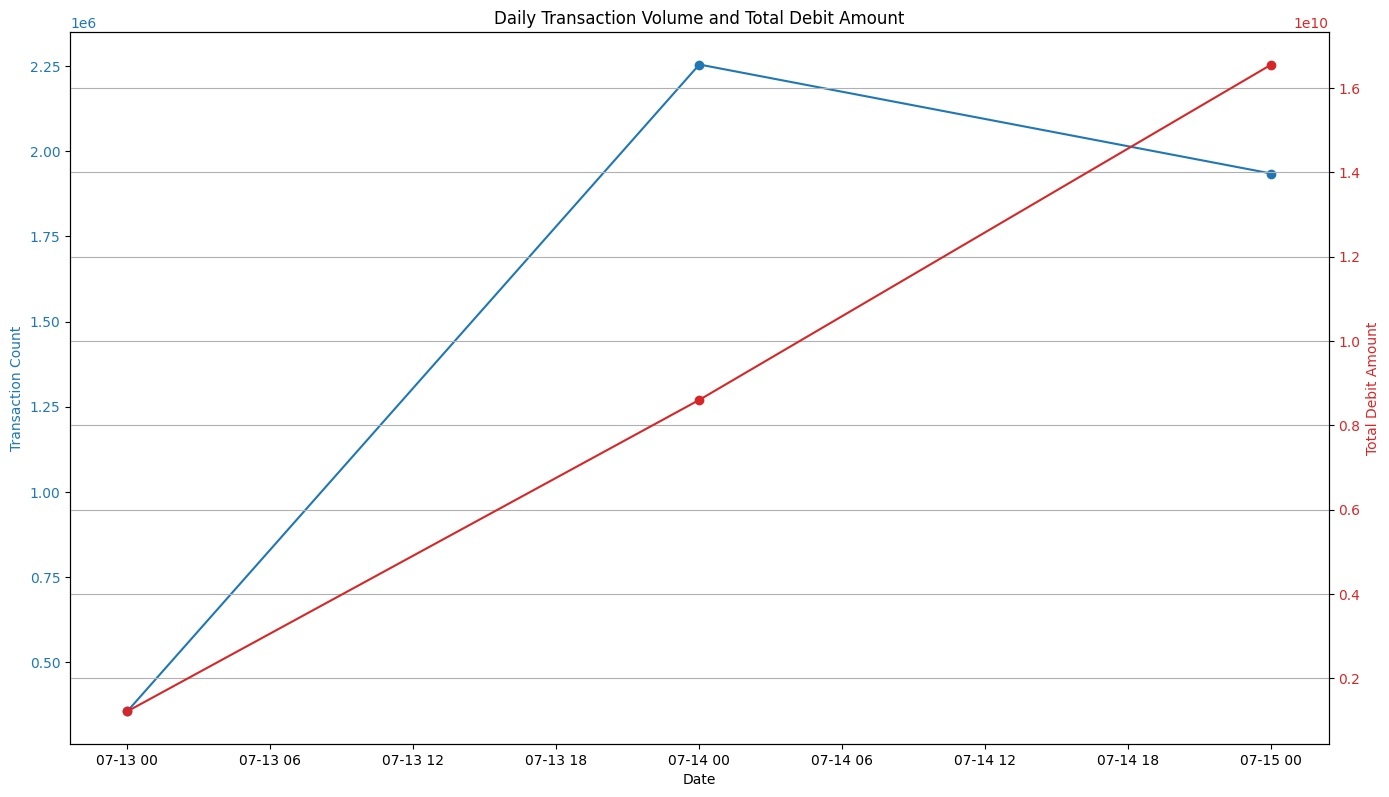

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
# Convert to Pandas DataFrame for plotting
daily_transactions_pd = daily_transactions.toPandas()

# Plotting
fig, ax1 = plt.subplots(figsize=(14, 8))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Transaction Count', color=color)
ax1.plot(daily_transactions_pd['date'], daily_transactions_pd['transaction_count'], marker='o', linestyle='-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Total Debit Amount', color=color)
ax2.plot(daily_transactions_pd['date'], daily_transactions_pd['total_debit_amount'], marker='o', linestyle='-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Daily Transaction Volume and Total Debit Amount')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:

from pyspark.sql import functions as F
import pandas as pd
import plotly.graph_objects as go


# Convert to Pandas DataFrame for plotting
daily_transactions_pd = daily_transactions.toPandas()

# Create a combined line chart with dual y-axes using Plotly
fig = go.Figure()

# Add a line trace for Transaction Count
fig.add_trace(go.Scatter(
    x=daily_transactions_pd['date'],
    y=daily_transactions_pd['transaction_count'],
    name='Transaction Count',
    mode='lines+markers',
    line=dict(color='blue'),
    yaxis='y1'
))

# Add a line trace for Total Debit Amount
fig.add_trace(go.Scatter(
    x=daily_transactions_pd['date'],
    y=daily_transactions_pd['total_debit_amount'],
    name='Total Debit Amount',
    mode='lines+markers',
    line=dict(color='red'),
    yaxis='y2'
))

# Update layout with dual y-axes
fig.update_layout(
    title='Daily Transaction Volume and Total Debit Amount',
    xaxis_title='Date',
    yaxis=dict(
        title='Transaction Count',
        titlefont=dict(color='blue'),
        tickfont=dict(color='blue')
    ),
    yaxis2=dict(
        title='Total Debit Amount',
        titlefont=dict(color='red'),
        tickfont=dict(color='red'),
        overlaying='y',
        side='right'
    ),
    width=1000,
    height=600,
    xaxis_tickformat='%Y-%m-%d',
    legend_title='Metrics'
)

fig.show()


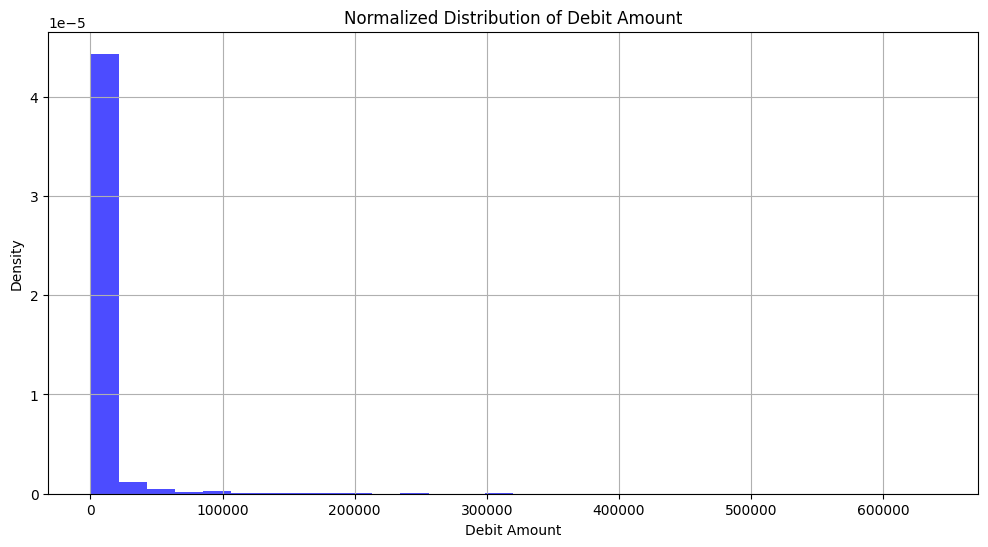

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to Pandas DataFrame for plotting
debit_amounts_pd = Cleaned_df.select("DEBIT_AMOUNT").toPandas()

plt.figure(figsize=(12, 6))
plt.hist(debit_amounts_pd['DEBIT_AMOUNT'], bins=30, density=True, alpha=0.7, color='blue')
plt.title('Normalized Distribution of Debit Amount')
plt.xlabel('Debit Amount')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Density Plot with Normalization
#plt.figure(figsize=(12, 6))
#sns.kdeplot(debit_amounts_pd['DEBIT_AMOUNT'], fill=True, color='blue')
#plt.title('Normalized Distribution of Debit Amount')
#plt.xlabel('Debit Amount')
#plt.ylabel('Density')
#plt.grid(True)
#plt.show()

**Transaction Amount Deviation**

In [ ]:

from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, col, abs, to_timestamp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Define a window spec partitioned by DEBIT_ACCT_NO and ordered by DATE_TIME
window_spec = Window.partitionBy("DEBIT_ACCT_NO").orderBy("DATE_TIME")

# Calculate the previous transaction amount for each debit account
Cleaned_df = Cleaned_df.withColumn("prev_debit_amount", F.lag("DEBIT_AMOUNT").over(window_spec))

# Calculate the absolute deviation from the previous transaction amount
Cleaned_df = Cleaned_df.withColumn("debit_amount_deviation", F.abs(F.col("DEBIT_AMOUNT") - F.col("prev_debit_amount")))

# Show some of the results
Cleaned_df.show(5)


+------------+-------------+------------+--------------+-------------------+------------------+--------------+-----------------+----------------------+
|         KEY|DEBIT_ACCT_NO|DEBIT_AMOUNT|DEBIT_CUSTOMER|          DATE_TIME|  transaction_type|CREDIT_ACCT_NO|prev_debit_amount|debit_amount_deviation|
+------------+-------------+------------+--------------+-------------------+------------------+--------------+-----------------+----------------------+
|FT24197QPHNB|1000000001086|        30.0|    1000099234|2024-07-14 21:21:00|             Popup|    0913094293|             null|                  null|
|FT24197QZKWZ|1000000001418|       100.0|    1000098016|2024-07-14 19:11:00|             Popup|    0920889552|             null|                  null|
|FT241978X5JK|1000000001485|        50.0|    1000097577|2024-07-15 14:10:00|             Popup|    0911110923|             null|                  null|
|FT2419749750|1000000001582|       100.0|    1000097140|2024-07-15 13:40:00|Account to a

**Time Since Last Transaction**

In [ ]:
# Time Since Last Transaction
#Calculate the previous transaction amount for each debit account
Cleaned_df = Cleaned_df.withColumn("prev_transaction_time", F.lag("DATE_TIME").over(window_spec))
Cleaned_df = Cleaned_df.withColumn("time_since_last_transaction",
                                   F.unix_timestamp("DATE_TIME") - F.unix_timestamp("prev_transaction_time"))
Cleaned_df.show()

+------------+-------------+------------+--------------+-------------------+------------------+--------------+-----------------+----------------------+---------------------+---------------------------+
|         KEY|DEBIT_ACCT_NO|DEBIT_AMOUNT|DEBIT_CUSTOMER|          DATE_TIME|  transaction_type|CREDIT_ACCT_NO|prev_debit_amount|debit_amount_deviation|prev_transaction_time|time_since_last_transaction|
+------------+-------------+------------+--------------+-------------------+------------------+--------------+-----------------+----------------------+---------------------+---------------------------+
|FT24197QPHNB|1000000001086|        30.0|    1000099234|2024-07-14 21:21:00|             Popup|    0913094293|             null|                  null|                 null|                       null|
|FT24197QZKWZ|1000000001418|       100.0|    1000098016|2024-07-14 19:11:00|             Popup|    0920889552|             null|                  null|                 null|                   

In [ ]:
from pyspark.sql import functions as F


Cleaned_df = Cleaned_df.drop('prev_debit_amount', 'prev_transaction_time')

# Show the DataFrame to verify the changes
Cleaned_df.show()


+------------+-------------+------------+--------------+-------------------+------------------+--------------+----------------------+---------------------------+
|         KEY|DEBIT_ACCT_NO|DEBIT_AMOUNT|DEBIT_CUSTOMER|          DATE_TIME|  transaction_type|CREDIT_ACCT_NO|debit_amount_deviation|time_since_last_transaction|
+------------+-------------+------------+--------------+-------------------+------------------+--------------+----------------------+---------------------------+
|FT24197QPHNB|1000000001086|        30.0|    1000099234|2024-07-14 21:21:00|             Popup|    0913094293|                  null|                       null|
|FT24197QZKWZ|1000000001418|       100.0|    1000098016|2024-07-14 19:11:00|             Popup|    0920889552|                  null|                       null|
|FT241978X5JK|1000000001485|        50.0|    1000097577|2024-07-15 14:10:00|             Popup|    0911110923|                  null|                       null|
|FT2419749750|1000000001582|

In [ ]:
Cleaned_df = Cleaned_df.fillna(0)
Cleaned_df.show()

+------------+-------------+------------+--------------+-------------------+------------------+--------------+----------------------+---------------------------+
|         KEY|DEBIT_ACCT_NO|DEBIT_AMOUNT|DEBIT_CUSTOMER|          DATE_TIME|  transaction_type|CREDIT_ACCT_NO|debit_amount_deviation|time_since_last_transaction|
+------------+-------------+------------+--------------+-------------------+------------------+--------------+----------------------+---------------------------+
|FT24197QPHNB|1000000001086|        30.0|    1000099234|2024-07-14 21:21:00|             Popup|    0913094293|                   0.0|                          0|
|FT24197QZKWZ|1000000001418|       100.0|    1000098016|2024-07-14 19:11:00|             Popup|    0920889552|                   0.0|                          0|
|FT241978X5JK|1000000001485|        50.0|    1000097577|2024-07-15 14:10:00|             Popup|    0911110923|                   0.0|                          0|
|FT2419749750|1000000001582|

In [ ]:
from pyspark.sql import functions as F

# Group by DEBIT_ACCT_NO and calculate the required statistics
stats_df = Cleaned_df.groupBy('DEBIT_ACCT_NO').agg(
    F.mean('debit_amount_deviation').alias('debit_amount_deviation_mean'),
    F.max('debit_amount_deviation').alias('debit_amount_deviation_max'),
    F.min('debit_amount_deviation').alias('debit_amount_deviation_min'),
    F.stddev('debit_amount_deviation').alias('debit_amount_deviation_std'),
    F.mean('time_since_last_transaction').alias('time_since_last_transaction_mean'),
    F.max('time_since_last_transaction').alias('time_since_last_transaction_max'),
    F.min('time_since_last_transaction').alias('time_since_last_transaction_min'),
    F.stddev('time_since_last_transaction').alias('time_since_last_transaction_std')
)

# Show the resulting DataFrame
stats_df.fillna(0).show()


+-------------+---------------------------+--------------------------+--------------------------+--------------------------+--------------------------------+-------------------------------+-------------------------------+-------------------------------+
|DEBIT_ACCT_NO|debit_amount_deviation_mean|debit_amount_deviation_max|debit_amount_deviation_min|debit_amount_deviation_std|time_since_last_transaction_mean|time_since_last_transaction_max|time_since_last_transaction_min|time_since_last_transaction_std|
+-------------+---------------------------+--------------------------+--------------------------+--------------------------+--------------------------------+-------------------------------+-------------------------------+-------------------------------+
|1000000001086|                        0.0|                       0.0|                       0.0|                       0.0|                             0.0|                              0|                              0|                 

In [ ]:
Pre_feature_account=credit_count_per_debit.join(unique_credit_per_debit, on="DEBIT_ACCT_NO",how="left")
Pre_feature_account=Pre_feature_account.join(transaction_type_per_debit, on="DEBIT_ACCT_NO",how="left")
Pre_feature_account=Pre_feature_account.join(Transaction_By_Debit_Account,on="DEBIT_ACCT_NO",how="left")
Pre_feature_account.show()

+-------------+-------------------+----------------------+--------------------+------------------------+--------------------------+----------------------+
|DEBIT_ACCT_NO|unique_credit_count|unique_credit_accounts|   transaction_types|total_transaction_amount|Average Transaction Amount|Transaction Ferequency|
+-------------+-------------------+----------------------+--------------------+------------------------+--------------------------+----------------------+
|1000020302236|                  5|  [1000529290318, 1...|[Account to account]|                  8881.0|                    1776.2|                     5|
|1000040822686|                  3|  [0916052988, 0941...|[Account to accou...|                  8659.9|         2886.633333333333|                     3|
|1000128436921|                  5|  [1000318544817, 1...|[Account to accou...|                107675.0|        17945.833333333332|                     6|
|1000147373442|                  1|          [0927558986]|            

In [ ]:
Final_feature=Pre_feature_account.join( stats_df,on="DEBIT_ACCT_NO",how="left")
#Final_feature.fillna(0).show()

In [ ]:
#Final_feature=Final_feature.fillna(0)

In [ ]:
Final_feature_ex_TT_UCA=Final_feature.select("DEBIT_ACCT_NO","unique_credit_count","total_transaction_amount","Average Transaction Amount","Transaction Ferequency","debit_amount_deviation_mean","debit_amount_deviation_max","debit_amount_deviation_std","time_since_last_transaction_max","time_since_last_transaction_std","time_since_last_transaction_mean")
Final_feature_ex_TT_UCA

DataFrame[DEBIT_ACCT_NO: string, unique_credit_count: bigint, total_transaction_amount: double, Average Transaction Amount: double, Transaction Ferequency: bigint, debit_amount_deviation_mean: double, debit_amount_deviation_max: double, debit_amount_deviation_std: double, time_since_last_transaction_max: bigint, time_since_last_transaction_std: double, time_since_last_transaction_mean: double]

In [ ]:
Final_feature_ex_TT_UCA=Final_feature_ex_TT_UCA.fillna(0)
Final_feature_ex_TT_UCA.show()

+-------------+-------------------+------------------------+--------------------------+----------------------+---------------------------+--------------------------+--------------------------+-------------------------------+-------------------------------+--------------------------------+
|DEBIT_ACCT_NO|unique_credit_count|total_transaction_amount|Average Transaction Amount|Transaction Ferequency|debit_amount_deviation_mean|debit_amount_deviation_max|debit_amount_deviation_std|time_since_last_transaction_max|time_since_last_transaction_std|time_since_last_transaction_mean|
+-------------+-------------------+------------------------+--------------------------+----------------------+---------------------------+--------------------------+--------------------------+-------------------------------+-------------------------------+--------------------------------+
|1000020302236|                  5|                  8881.0|                    1776.2|                     5|                    

In [ ]:
Final_feature_ex_TT_UCA_Pd=Final_feature_ex_TT_UCA.toPandas()
Final_feature_ex_TT_UCA_Pd

,DEBIT_ACCT_NO,unique_credit_count,total_transaction_amount,Average Transaction Amount,Transaction Ferequency,debit_amount_deviation_mean,debit_amount_deviation_max,debit_amount_deviation_std,time_since_last_transaction_max,time_since_last_transaction_std,time_since_last_transaction_mean
0,1000000001086,1,30.0,30.00,1,0.00,0.0,0.000000,0,0.000000,0.0
1,1000000001418,1,100.0,100.00,1,0.00,0.0,0.000000,0,0.000000,0.0
2,1000000001434,1,130.0,65.00,2,15.00,30.0,21.213203,420,296.984848,210.0
3,1000000001485,1,50.0,50.00,1,0.00,0.0,0.000000,0,0.000000,0.0
4,1000000001582,1,100.0,100.00,1,0.00,0.0,0.000000,0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2216136,1008485333333,1,100.0,100.00,1,0.00,0.0,0.000000,0,0.000000,0.0
2216137,1008888888882,1,40000.0,40000.00,1,0.00,0.0,0.000000,0,0.000000,0.0
2216138,1009066666655,1,330.0,165.00,2,155.00,310.0,219.203102,720,509.116882,360.0
2216139,1009595959595,3,3620.0,905.00,4,840.00,3180.0,1562.305988,88800,42779.004196,25140.0


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import c
from pyspark.ml.feature import  VectorAssembler, StandardScaler, Imputer
from pyspark.ml import Pipeline

In [ ]:
anomaly_input=["unique_credit_count","total_transaction_amount","Average Transaction Amount","Transaction Ferequency","debit_amount_deviation_mean","debit_amount_deviation_max","debit_amount_deviation_std","time_since_last_transaction_max","time_since_last_transaction_std","time_since_last_transaction_mean"]


In [ ]:
from sklearn.ensemble import IsolationForest

# Initialize Isolation Forest
isolation_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)

# Fit the model
isolation_forest.fit(Final_feature_ex_TT_UCA_Pd[anomaly_input])

# Predict anomalies
anomaly_scores = isolation_forest.decision_function(Final_feature_ex_TT_UCA_Pd[anomaly_input])
predictions = isolation_forest.predict(Final_feature_ex_TT_UCA_Pd[anomaly_input])


Final_feature_ex_TT_UCA_Pd['anomaly_scores']=anomaly_scores
Final_feature_ex_TT_UCA_Pd['anomaly']=predictions




In [ ]:
Final_feature_ex_TT_UCA_Pd

,DEBIT_ACCT_NO,unique_credit_count,total_transaction_amount,Average Transaction Amount,Transaction Ferequency,debit_amount_deviation_mean,debit_amount_deviation_max,debit_amount_deviation_std,time_since_last_transaction_max,time_since_last_transaction_std,time_since_last_transaction_mean,anomaly_scores,anomaly
0,1000000001086,1,30.0,30.00,1,0.00,0.0,0.000000,0,0.000000,0.0,0.401692,1
1,1000000001418,1,100.0,100.00,1,0.00,0.0,0.000000,0,0.000000,0.0,0.400712,1
2,1000000001434,1,130.0,65.00,2,15.00,30.0,21.213203,420,296.984848,210.0,0.361622,1
3,1000000001485,1,50.0,50.00,1,0.00,0.0,0.000000,0,0.000000,0.0,0.401219,1
4,1000000001582,1,100.0,100.00,1,0.00,0.0,0.000000,0,0.000000,0.0,0.400712,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2216136,1008485333333,1,100.0,100.00,1,0.00,0.0,0.000000,0,0.000000,0.0,0.400712,1
2216137,1008888888882,1,40000.0,40000.00,1,0.00,0.0,0.000000,0,0.000000,0.0,0.286906,1
2216138,1009066666655,1,330.0,165.00,2,155.00,310.0,219.203102,720,509.116882,360.0,0.339505,1
2216139,1009595959595,3,3620.0,905.00,4,840.00,3180.0,1562.305988,88800,42779.004196,25140.0,0.278372,1


In [ ]:
import seaborn as sns
from seaborn import FacetGrid
from seaborn import scatterplot
import matplotlib.pyplot as plt

def outlier_plot(data, method, x_var, y_var, xaxis_limits=[0, 1], yaxis_limits=[0, 1]):
    print(f'Outlier method: {method}')
    print(f"Number of anomalies: {len(data[data['anomaly'] == -1])}")
    print(f"Number of non-anomalies: {len(data[data['anomaly'] == 1])}")
    print(f"Total number of values: {len(data)}")

    g = FacetGrid(data, col='anomaly', height=4, hue='anomaly', hue_order=[1, -1])
    g.map(scatterplot, x_var, y_var)
    g.fig.suptitle(f'Outlier method: {method}', y=1.05, fontweight='bold')
    g.set(xlim=xaxis_limits, ylim=yaxis_limits)

    axes = g.axes.flatten()
    axes[0].set_title(f"Non-outliers\n{len(data[data['anomaly'] == 1])} points")
    axes[1].set_title(f"Outliers\n{len(data[data['anomaly'] == -1])} points")

    return g






In [ ]:
import seaborn as sns
from seaborn import FacetGrid
from seaborn import scatterplot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def outlier_plots(data, method, x_var, y_var, xaxis_limits=[0, 1], yaxis_limits=[0, 1], xaxis_step=5):
    print(f'Outlier method: {method}')
    print(f"Number of anomalies: {len(data[data['anomaly'] == -1])}")
    print(f"Number of non-anomalies: {len(data[data['anomaly'] == 1])}")
    print(f"Total number of values: {len(data)}")

    g = FacetGrid(data, col='anomaly', height=4, hue='anomaly', hue_order=[1, -1])
    g.map(scatterplot, x_var, y_var)

    # Set the title for the entire figure
    g.fig.suptitle(f'Outlier method: {method}', y=1.08, fontweight='bold')

    # Adjust the x and y axis limits
    g.set(xlim=xaxis_limits, ylim=yaxis_limits)

    # Set custom titles for each subplot
    axes = g.axes.flatten()
    axes[0].set_title(f"Non-outliers\n{len(data[data['anomaly'] == 1])} points", y=1.03)
    axes[1].set_title(f"Outliers\n{len(data[data['anomaly'] == -1])} points", y=1.03)

    # Set x-axis ticks with a step of 5
    x_ticks = np.arange(xaxis_limits[0], xaxis_limits[1] + 1, xaxis_step)
    for ax in axes:
        ax.set_xticks(x_ticks)

    # Adjust layout parameters to increase space between plots
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    return g



Outlier method: Isolation Forest
Number of anomalies: 22161
Number of non-anomalies: 2193980
Total number of values: 2216141


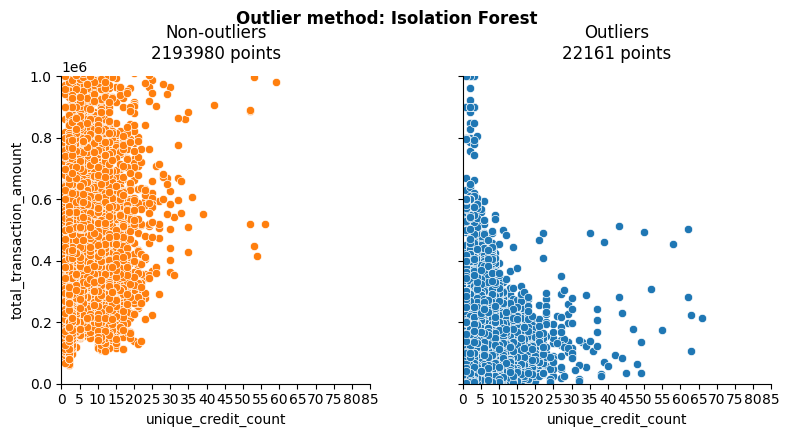

In [ ]:

outlier_plots(Final_feature_ex_TT_UCA_Pd, 'Isolation Forest', 'unique_credit_count', 'total_transaction_amount', xaxis_limits=[0, 85], yaxis_limits=[0, 1000000])
plt.show()

In [ ]:
# Correlation matrix
correlation_matrix = Final_feature_ex_TT_UCA_Pd.corr()
print(correlation_matrix)

                                  DEBIT_ACCT_NO  unique_credit_count  \
DEBIT_ACCT_NO                          1.000000             0.004734   
unique_credit_count                    0.004734             1.000000   
total_transaction_amount               0.004537             0.364643   
Average Transaction Amount             0.002991             0.098481   
Transaction Ferequency                 0.006932             0.888522   
debit_amount_deviation_mean            0.003071             0.277763   
debit_amount_deviation_max             0.003658             0.343063   
debit_amount_deviation_std             0.003227             0.274659   
time_since_last_transaction_max        0.004192             0.467194   
time_since_last_transaction_std        0.003079             0.327585   
time_since_last_transaction_mean       0.003103             0.321325   
anomaly_scores                        -0.005314            -0.662070   
anomaly                               -0.003557            -0.21

In [ ]:
palete=['#ff7f0e','#1f77b4']
sns.pairplot(Final_feature_ex_TT_UCA_Pd,hue='anomaly',palette=palete)